### Handbag Detection from Images

This is a tutorial for handbag detection from images using pretrained faster_rcnn model

In [1]:
import os
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [2]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [3]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

#### Load Model

In [4]:
def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=base_url + model_file,
        untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"

    model = tf.saved_model.load(str(model_dir))
    model = model.signatures['serving_default']

    return model

In [5]:
model_name = 'faster_rcnn_inception_v2_coco_2018_01_28'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


The structure of output from object detection is shown below

In [9]:
detection_model.output_shapes

{'detection_classes': TensorShape([None, 100]),
 'num_detections': TensorShape([None]),
 'detection_boxes': TensorShape([None, 100, 4]),
 'detection_scores': TensorShape([None, 100])}

#### Load Classes Information

In [10]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/Users/jianinglu1/Documents/GitHub/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

The handbag is class 31 in category_index

#### Get Detection Results

In [15]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    output_dict = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

In [17]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
    #print(image_np)
  # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    #print(output_dict["detection_masks_reframed"])
    #print(output_dict["detection_boxes"])l
  # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks_reframed', None),
            use_normalized_coordinates=True,
            line_thickness=8,
            min_score_thresh=0.0
            )

    display(Image.fromarray(image_np))

Object detection result is shown below

In [18]:
os.getcwd()

'/Users/jianinglu1/Documents/GitHub/DataInsight/tutorials'

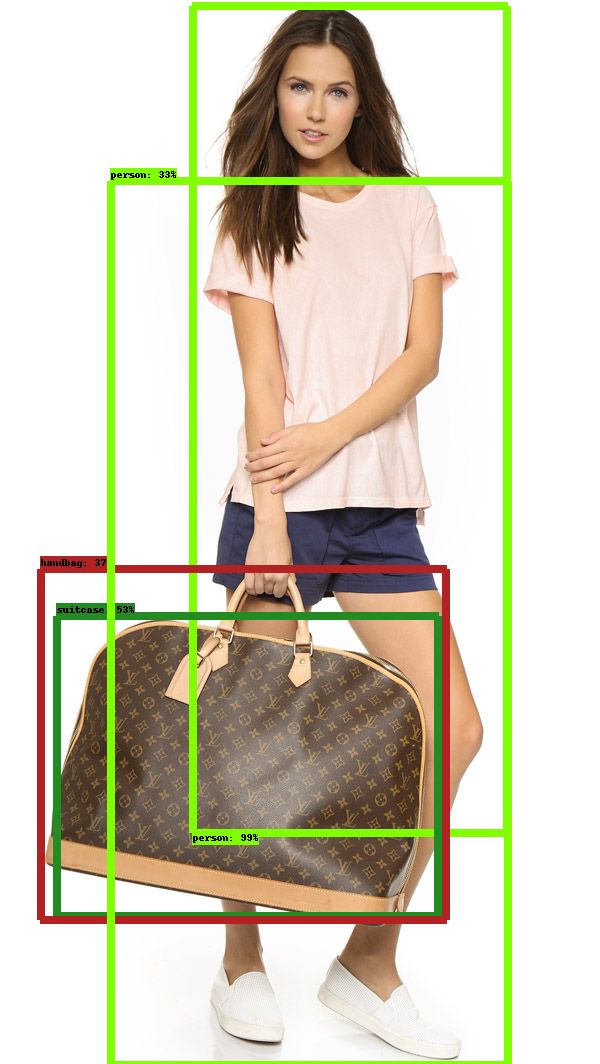

In [23]:
image_path = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/example/307.jpg"
show_inference(detection_model, image_path)

It is clearly that the handbag has been detected from image.

#### Crop Images

Based on the handbag detection results (class: 31, box infor), we can crop the image and only keep the handbag from original image

In [37]:
def crop_image(name, path, outpath, model, show=True, save=True):
    image = Image.open(os.path.join(path,name))
    if show:
        display(image)
    width, hight = image.size
    image_np = np.array(image)
    output_dict = run_inference_for_single_image(model, image_np)
    if 31 in output_dict["detection_classes"]:
        max_score =  max([output_dict["detection_scores"][idx] for idx, i in enumerate(output_dict["detection_classes"]) if i == 31])
        index = list(output_dict["detection_scores"]).index(max_score) 
        [y,x,h,w] = output_dict["detection_boxes"][index]
        cropped = image_np[int(y*hight):int(h*hight), int(x*width):int(w*width)]
        if show:
            img = Image.fromarray(cropped,"RGB")
            display(img)
        if save:
            img = Image.fromarray(cropped,"RGB")
            img.save(os.path.join(outpath, name))
        return True
    else:
        return False

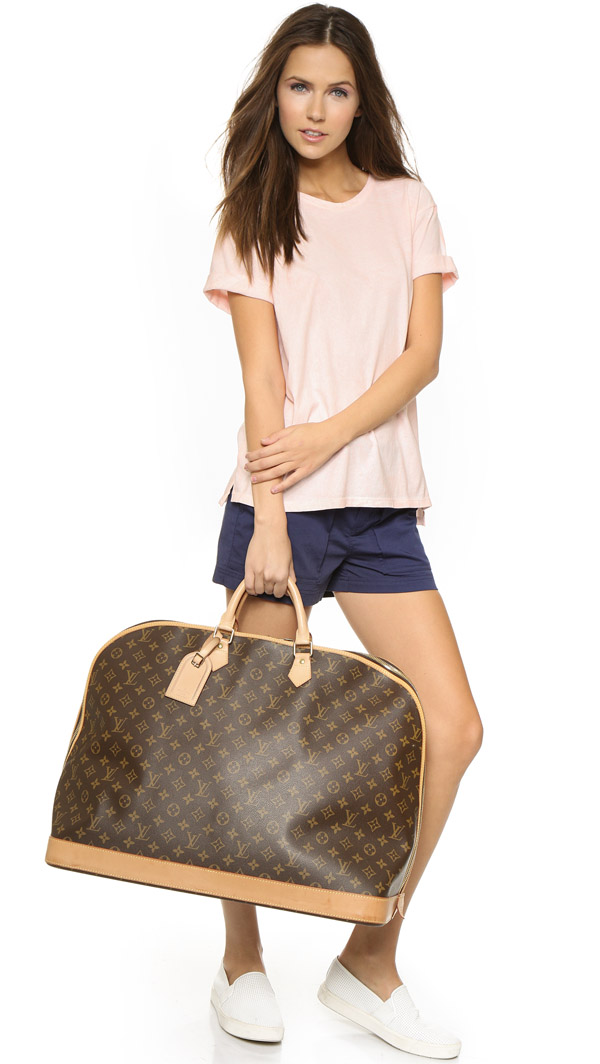

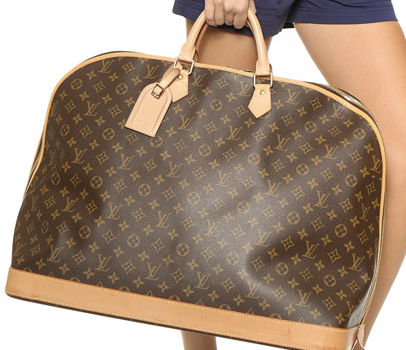

True

In [38]:
path = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/example/"
outpath = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/example/cropped/"
name = "307.jpg"
crop_image(name, path, outpath, model=detection_model, show=True, save=True)

The original image has been cropped into handbag image

#### Prepare Preprocessed data

Finally, we need rename our original clean data, and conduct the handbag detection and put the cropped images into preprocessed directory.

In [40]:
def rename(path):
    olddir = os.getcwd()
    os.chdir(path)
    images = [ i for i in os.listdir(path) if i.split(".")[1] in ["png","gif","jpeg","jpg"] ]
    for idx, i in enumerate(images):
        if i.split(".")[1] in ["png","gif","jpeg"]:
            im = Image.open(i)
            rgb_im = im.convert('RGB')
            rgb_im.save(i.split(".")[0] + ".jpg")
            os.system("rm " + i )
        os.system("cp " + i.split(".")[0] + ".jpg " + str(idx) + ".jpg")
    os.chdir(olddir)
    return len(images)

In [41]:
def rename_otherbag(path):
    olddir = os.getcwd()
    os.chdir(path)
    images = [ i for i in os.listdir(path) if i.split(".")[1] in ["png","gif","jpeg","jpg"] ]
    for idx, i in enumerate(images):
        if " " in i:
            os.system("cp " + i.split()[0] + "\ " + i.split()[1].split(".")[0] + ".jpg " + str(idx) + ".jpg")
        else:
            os.system("cp " + i.split(".")[0] + ".jpg " + str(idx) + ".jpg")
    os.chdir(olddir)
    return len(images)

In [52]:
for i in ["jetsettote","mercertotebag","selmasatchel"]:
    number = rename("/Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/MK/" + i)
    path = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/MK/" + i
    outpath = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/processed/MK/" + i
    for i in range(number):
        name = str(i) + ".jpg"
        try:
            if not crop_image(name, path, outpath, show=False):
                print(i)
        except:
            print(i)

0
2
3
5
6
7
8
10
11
12
13
14
15
16
17
18
19
20
21
23
24
27
28
32
33
35
38
39
40
43
45
48
49
50
51
53
55
59
60
61
62
65
69
74
76
78
80
81
83
84
85
86
87
88
91
94
95
100
101
102
105
106
107
109
110
112
113
114
115
116
117
120
124
127
128
129
130
134
138
139
140
142
144
147
148
151
152
154
158
159
164
165
169
171
172
175
176
177
179
183
184
185
187
189
192
193
194
198
199
202
203
204
205
206
207
212
213
215
216
217
218
219
220
221
223
224
225
226
227
229
230
231
232
233
234
2
4
5
7
9
11
16
17
19
20
21
23
26
30
31
33
34
37
38
40
41
43
44
46
48
50
51
54
55
56
57
59
61
62
67
68
70
71
74
81
83
84
88
89
90
95
99
100
102
108
109
110
111
113
116
118
120
121
122
127
129
132
133
136
138
139
140
142
149
151
152
153
154
155
157
158
159
160
161
163
169
173
175
176
178
179
180
182
186
189
190
191
193
194
195
196
198
199
202
203
205
212
213
214
215
218
219
221
222
223
224
225
226
227
229
233
236
238
240
241
242
246
251
252
253
254
257
261
264
265
268
269
270
272
273
276
277
285
287
290
293
295
296
297


In [ ]:
path = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/other"
outpath = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other"
for i in range(4993):
    name = str(i) + ".jpg"
    try:
        if not crop_image(name, path, outpath, show=False):
            print(i)
    except:
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
223
224
225
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
2

1898
1899
1900
1901
1902
1903
1904
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
